<h1 style="text-align: center;">Trabalho Computacional - Otimização - 2022.2</p>

**Universidade Federal do Rio de Janeiro - PESC**  
**Professores:** Laura Bahiense e Luidi Simonetti  
**Alunos:** Leonardo Nunes Guimarães Costa e Victor Ribeiro 

## 1 - Objetivo e Especificações


Minimizar computacionalmente a seguinte função:

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad 
\end{equation*}

### 1.1 - Bibliotecas usadas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from tabulate import tabulate
from random import randint, random
from operator import add

### 1.2 - Funções Necessárias


#### Calculo da Função em um Ponto

In [2]:
def funcValue(x1, x2):
        return np.sqrt(np.log(x1)**2 + np.log(x2)**2)

#### Calculo do Gradiente em um Ponto


In [3]:
def gradValue(x1,x2):
    denom = funcValue(x1,x2)
    return np.log(x1)/(denom*x1), np.log(x2)/(denom*x2)

#### Calculo da Hessiana em um Ponto


In [4]:
def hessianValue(x1,x2):
    if(x1 <= 0 or x2 <= 0 ): return (np.inf)*3
    log1, log2 = np.log(x1), np.log(x2)
    func, func3 = funcValue(x1,x2), (log1**2 + log2**2)**(1.5)
    a1 = (1/x1**2)*(((1-log1)/(func))-(log1**2/func3))
    a2 = (1/x2**2)*(((1-log2)/(func))-(log2**2/func3))
    b = (-1)*(log1*log2)/(x1*x2*func3)
    return [[a1, b],[b,a2]]

#### Calculo dos Autovalores de uma Matriz

In [5]:
def eigenValues(matrix):
    hdelta, avg = np.sqrt((matrix[0][0]-matrix[1][1])**2 + matrix[0][1]**2)/2, (matrix[0][0] + matrix[1][1])/2
    ev1 = avg + hdelta
    ev2 = avg - hdelta
    return ev1, ev2

#### Checar Convexidade a Partir da Definição da Matriz

In [6]:
def checkConvexity(ev1,ev2):
    if (ev1 > 0 and ev2 > 0): return 1
    elif (ev1 < 0 and ev2 < 0): return -1
    else: return False

#### Iteração do BFGS

In [7]:
def bfgs(H, p, q):
    p_t = np.transpose(p)
    q_t = np.transpose(q)
    denominator = np.dot(p_t, q)
    if denominator:
        term_1 = (1+((np.linalg.multi_dot([q_t, H, q]))/denominator))
        term_2 = (np.dot(p, p_t))/denominator
        term_3 = ((np.dot(np.dot(p, q_t), H))+(np.dot(np.dot(H, q), p)))/denominator
        return H + (term_1*term_2) - term_3
    else: return H
    

#### Direção de um Vetor

In [8]:
def direction(x,y):
    denom = np.sqrt(x**2 + y**2)
    return [x/denom , y/denom]
    

#### Trunco de Float do Python

In [9]:
def truncate(extensive, decimalSize):
    pointer = 0.1**decimalSize
    reduced = (extensive//pointer)*pointer
    residue = extensive - reduced
    return reduced, residue

#### Geração de Tabela comSimulações

In [10]:
def simulate(startingPointList, method, header):
    finalList = []
    pointPaths = []
    for point in startingPointList:
        lineOutput = method(point)
        pointPaths += [lineOutput['pointsStored']]
        finalList += [[lineOutput['startingPoint'][0],lineOutput['startingPoint'][1],lineOutput['iterations'],lineOutput['stepSizeCalls'],lineOutput['currentPoint'][0],lineOutput['currentPoint'][1],lineOutput['currentValue'],lineOutput['residual']]]
    finalTable = tabulate(finalList, headers=["X°(x1)","X°(x2)", "#Iteracoes", "#Cham.Armijo", "X*(x1)","X*(x2)", "f(X*)", "Erro de Aproximacao"],floatfmt=[".4f",".4f","","",".6f",".6f",".6f"],tablefmt="fancy_outline")
    print('\n',header,'\n')
    print(finalTable)
    return pointPaths

#### Geração de Pontos

In [11]:
def getPoint():
    return 1.0/randint(1,10) + 1.0*randint(0,10), 1.0/randint(1,10) + 1.0*randint(0,10)# 82,6% Planalto | 16,8% Paredes | 0,6% Canto

def getCANTO():
    return 1.0/randint(1,100), 1.0/randint(1,100)

def getPAREDE1():
    return 1.0*randint(1,100), 1.0/randint(1,100)

def getPAREDE2():
    return 1.0/randint(1,100), 1.0*randint(1,100)

def getPLANALTO():
    return 1.0*randint(1,500),1.0*randint(1,500) 

### 1.3 - Métodos para construir gráficos da função

#### Gráfico da Fução

In [12]:
def plotFunction(x1, x2):
    '''Dados os intervalos de x1 e x2, retorna os gráficos e curva de nível da função nesse intervalo.'''
    fig = plt.figure(figsize=(24,8))
    color = 'inferno'

    # First subplot
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    X1 = np.linspace(x1[0], x1[1])
    X2 = np.linspace(x2[0], x2[1])
    X1, X2 = np.meshgrid(X1, X2)
    Z = funcValue(X1, X2)
    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(25, 35)

    # Second subplot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(15, 205)


    # Third subplot - Contour line
    ax = fig.add_subplot(1, 3, 3)
    h = ax.contourf(X1, X2, Z, cmap=color)
    plt.axis('scaled')
    fig.colorbar(h, shrink=0.7)
    
    plt.show()

#### Caminho de Pontos das Iterações

In [13]:
def plotPath(points):
    '''Função para ilustrar uma curva de nível com os pontos que foram obtidos
    durante a execução do método de otimização.\n
    Entrada:
        points: Array de tuplas, onde cada tupla representa um ponto (x1, x2).
        iterations: Número de iterações até o ponto ótimo.'''

    x = [item[0] for item in points]
    y = [item[1] for item in points]

    max_x, max_y = max(x)+1, max(y)+1
    min_x, min_y = max(min(x)-0.5, 0.0001), max(min(y)-0.5, 0.0001)

    plt.figure()
    plt.title(f'Partindo de: {points[0]}\nÓtimo em: {points[-1]}\nEm {len(points)} iterações.')
    X1 = np.linspace(min_x, max_x)
    X2 = np.linspace(min_y, max_y)
    X1, X2 = np.meshgrid(X1, X2)
    Z = funcValue(X1, X2)
    plt.contourf(X1,X2,Z,cmap='inferno')
    plt.colorbar()
    plt.plot(x, y,'^-w')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.show()

##  2 - Estudo da Função

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad \Omega = R^2
\end{equation*}

###  2.1 - Regiões e Pontos Críticos

É possível determinar o domínio natural da função como o primeiro quadrante sem valores nulos:

\begin{equation*}
    \Omega = x_1, x_2 > 0
\end{equation*}

Como $x_1$ e $x_2$ apresentam o mesmo comportamento, portanto a função é simétrica para o plano $x_1 = x_2$.

##### Uma Aproximação Grosseira 

Já que $ln(1) = 0$, é possível observar que $f(x_k,0) = |ln(x_k)|$ o que permite dividir a função em 4 regiões de 3 tipos diferentes:

Para ($ 0 < x_1 < 1$ e $x_2 > 1$) ou ($ 0 < x_2 < 1$ e $x_1 >1$) são as "paredes" da função em que valores próximos dos planos $x_1 = 0$ ou $x_2 = 0$ divergem e de forma oposta ao se aproximar dos planos $x_1 = 1$ ou $x_2 = 1$ a função se aproxima de $ln(x_1)$ ou $ln(x_2)$ dependendo da parede em questão.

Para $ 0 < x_1,x_2 < 1$, é o "canto" da função onde as paredes se unem e seu comportamento é similar ao destas, divergindo na direção da origem e zerando na direção do ponto $(1,1)$.


Como ultimo tipo na região $ x_1,x_2 > 1$ existe o "planalto" que monotonamente diverge para $x_1$ ou $x_2$ crescentes.

##### Aprofundando

Para encontrar os pontos críticos, vamos calcular o gradiente da função.

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\partial{f(x_1, x_2)}}{\partial{x_1}}, \frac{\partial{f(x_1, x_2)}}{\partial{x_2}} \right)
\end{equation*}

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\ln(x_1)}{x_1\sqrt{\ln^2(x_1)+\ln^2(x_2)}}, \frac{\ln(x_2)}{x_2\sqrt{\ln^2(x_1)+\ln^2(x_2)}} \right)
\end{equation*}

Para o ponto crítico, devemos encontrar os valores de $ (x_1, x_2) $ em que o numerador seja igual a 0.

\begin{equation*}
    ( \ln(x_1), \ln(x_2) ) = (0,0) \qquad \Rightarrow \qquad (x_1, x_2) = (1,1)
\end{equation*}

Porém os denominadores também são 0 neste ponto, o que caracteriza uma indeterminação e verificando melhor o ponto (1,1) possui uma descontinuidade (de pulo) no gradiente. Não sendo um ponto estacionário e sim um "bico"( descontinuidade de salto) exatamente onde as 4 regiões descritas anteriormente se juntam.

### 2.2 - Convexidade das Regiões

Podemos testar a convexidade das regiões supracitadas uma a uma e a melhor ferramenta para tal é calcular a matriz hessiana da função e verificar nas regiões:

\begin{equation*}
  \nabla² f(x_1, x_2) = 
\end{equation*}

\begin{bmatrix} \frac{1 - ln(x_1)}{x_1² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_1)}{x_1²(ln²(x_1)+ln²(x_2))^{3/2}} & - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}}  \\ - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}} & \frac{1 - ln(x_2)}{x_2² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_2)}{x_2²(ln²(x_1)+ln²(x_2))^{3/2}} \end{bmatrix}



Como forma de entender melhor o comportamento da hessiana ao longo do domínio da função, criamos uma rotina para checar numericamente as regiões em que a hessiana é: Definida positiva, definida negativa e indefinida. Essas regiões estão na imagem abaixo.

![Hessiana_regioes](./Fig-10x10-02.png)

A figura demonstra que a divisão nas 4 regiões é realmente grosseira, pois as regiões descritas não coincidem com as regiões caracterizadas pela Hessiana. Não conseguimos investigar analiticamente as fronteiras reais entre regiões de diferentes convexidades.

### 2.3 - Visualização da Função

#### A Região do Canto:

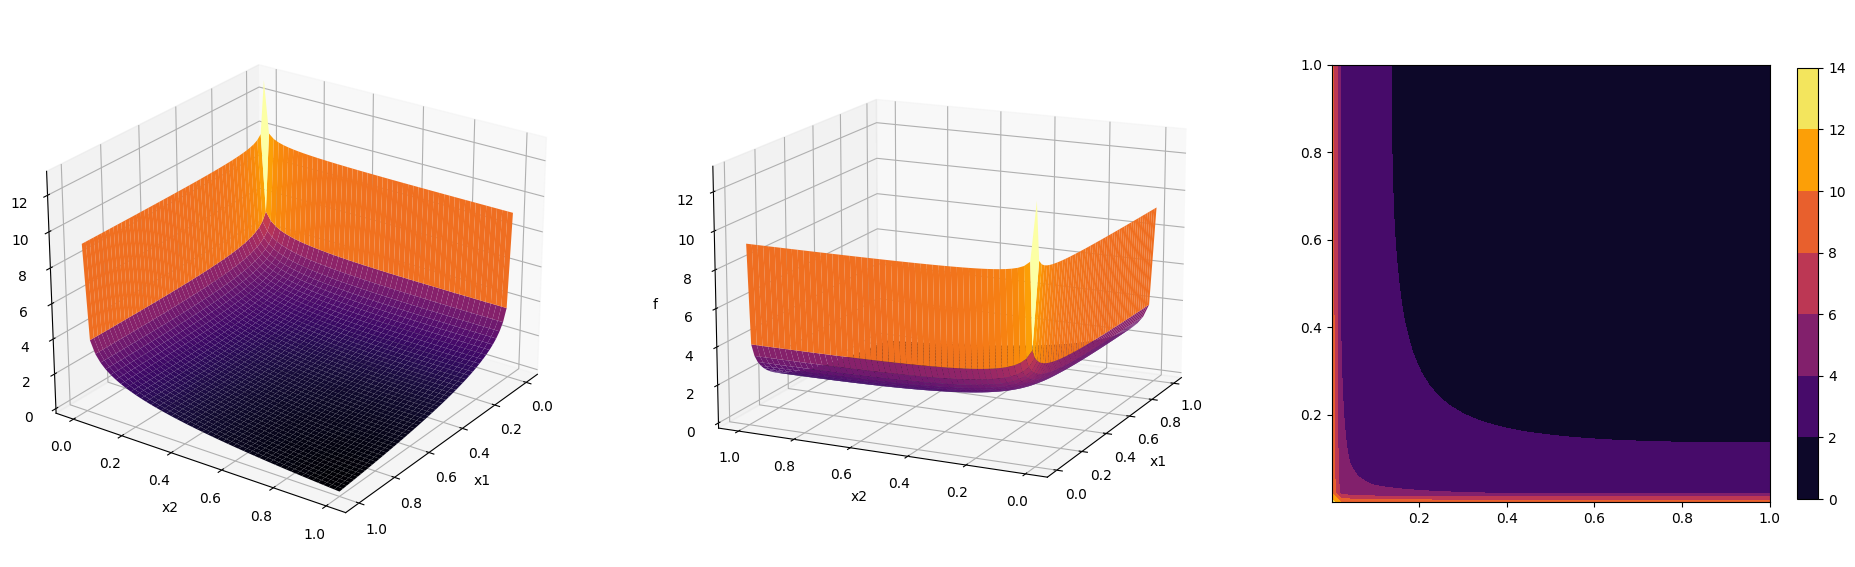

In [14]:
plotFunction(x1=[0.0001, 1.0], x2=[0.0001, 1.0])

#### A Parede ao Longo de $x_1$

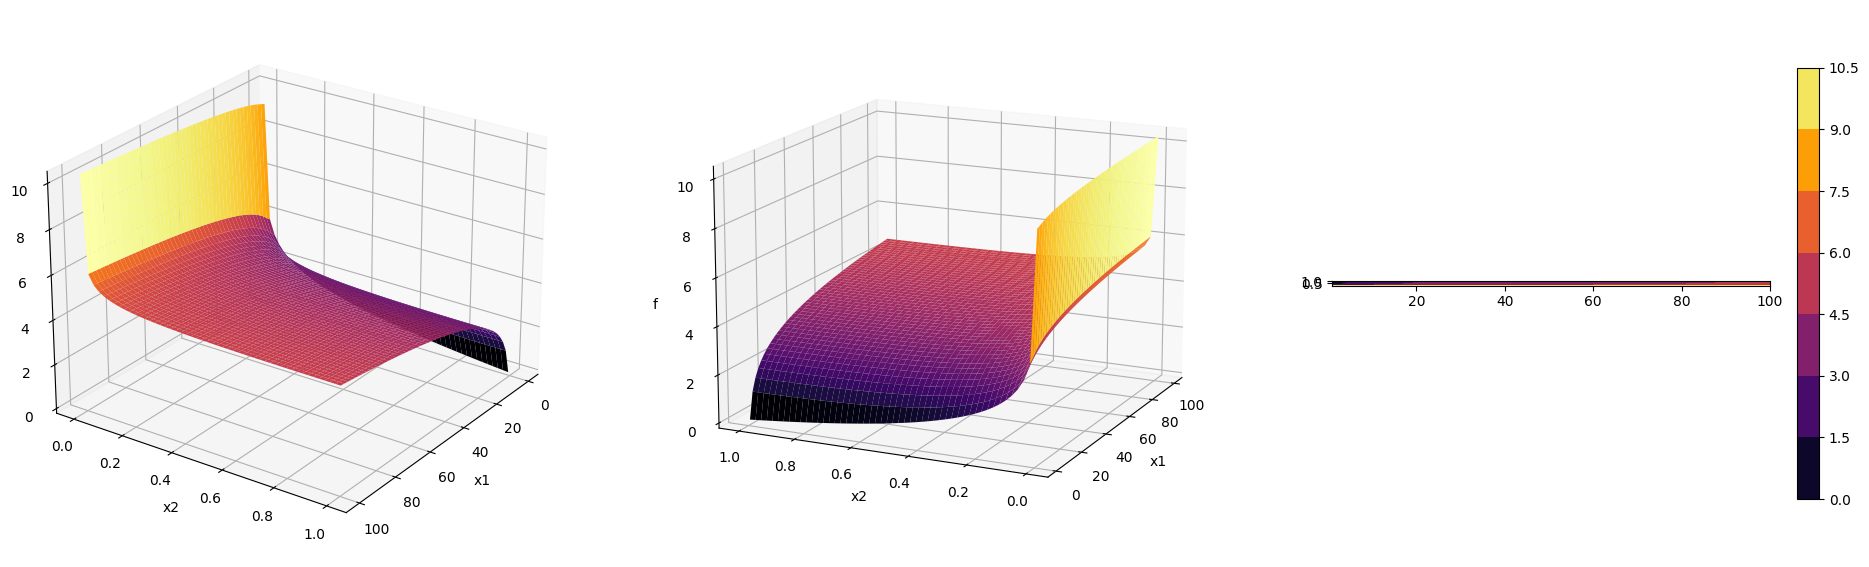

In [15]:
plotFunction(x1=[1.0, 100.0], x2=[0.0001, 1.0])

#### A Região do Planalto

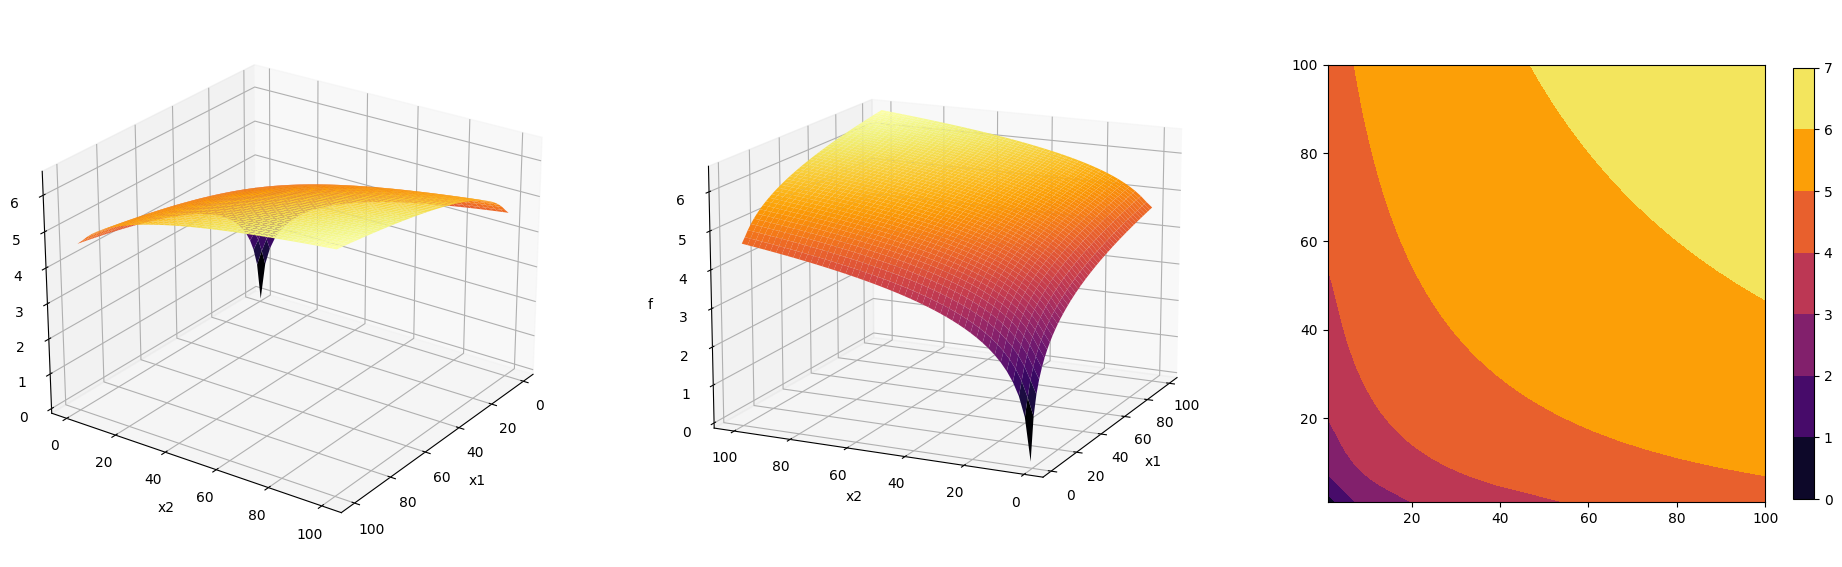

In [16]:
plotFunction(x1=[1.0, 100.0], x2=[1.0, 100.0])

Para compreender melhor o comportamento da função, foram utilizados os gráficos e curvas de nível abaixo, incluindo trechos das 4 regiões.

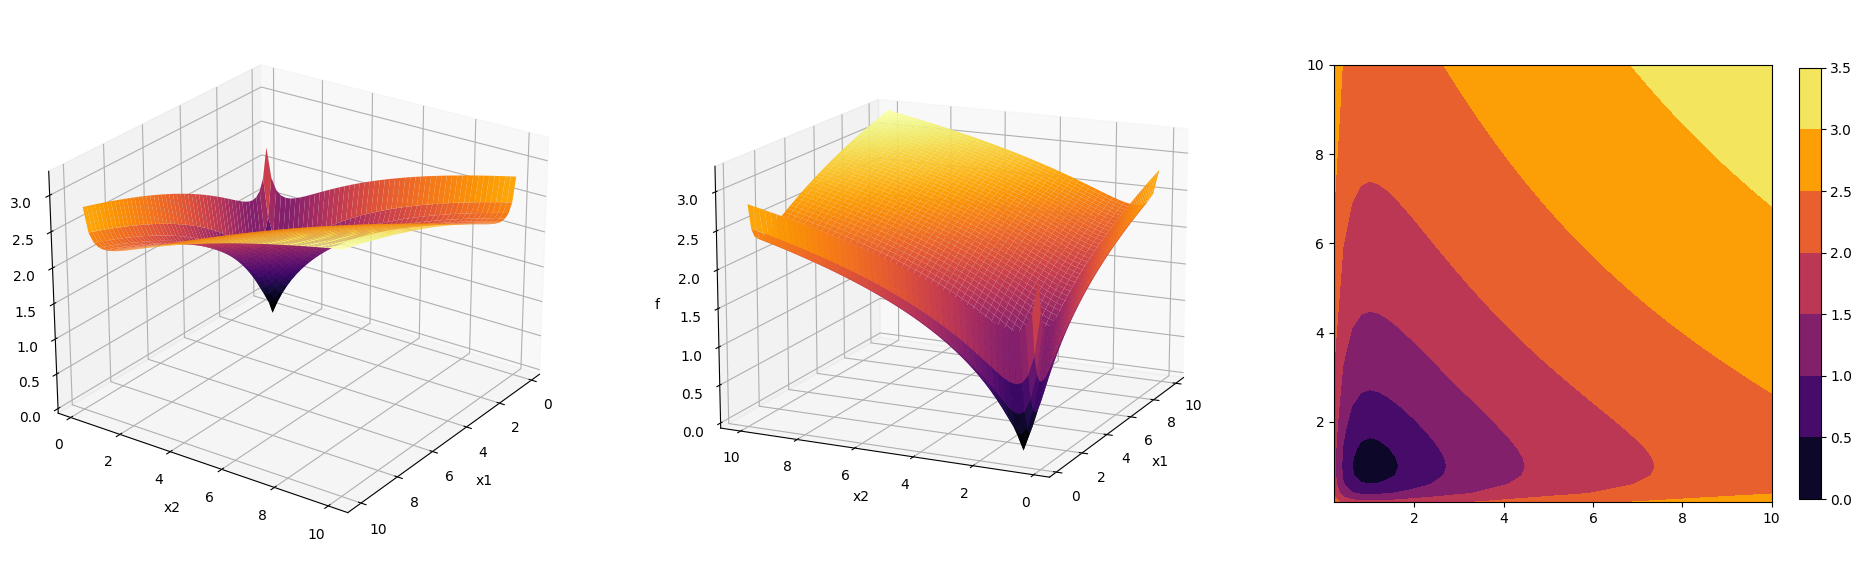

In [17]:
plotFunction(x1=[0.2, 10], x2=[0.2, 10])

Aproximando do bico em $(1,1)$

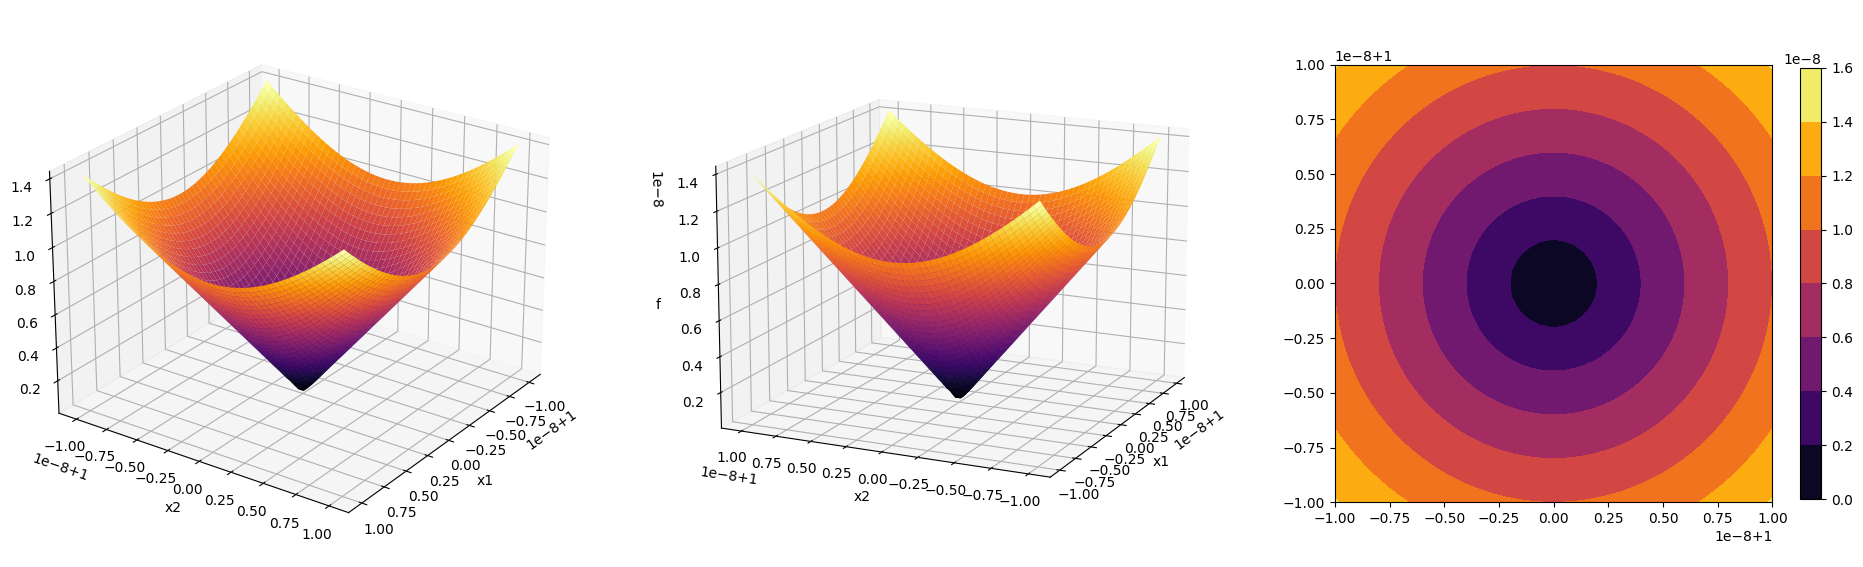

In [18]:
plotFunction(x1=[0.99999999, 1.00000001], x2=[0.99999999, 1.00000001])

## 3 - Implementação dos Métodos


### 3.1 - Tamanho de Passo pela Regra de Armijo

Tendo a direção de decrescimento e três parâmetros numéricos $S > 0$ e 0 < $\beta, \sigma < 1$ e também considerado um limite para as iterações:

In [19]:
def stepSize(state,direction, S , beta , sigma ,m = 0, iterationCap = 100):
    iterationRem = iterationCap - 1
    if iterationRem < 1:
        return stepSize(state,direction,np.sqrt(S),beta,sigma**2)
    state['stepSizeCalls'] += 1
    stepLength = sigma*(beta**m)*S
    newPoint = list(map(add,list(state['currentPoint']),[i * stepLength for i in list(direction)]))
    if(newPoint[0] > 0 and newPoint[1] > 0): 
        newValue = funcValue(newPoint[0],newPoint[1]) 
    else: newValue = np.inf
    
    if(state['currentValue'] < newValue):
        m += 1
        return stepSize(state, direction, S, beta, sigma, m, iterationRem)
    else:
        state['currentPoint'] = (newPoint[0],newPoint[1])
        state['currentValue'] = newValue
        return state, stepLength

### 3.2 - Método do Gradiente

In [20]:
def gradientMethod(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 2.7, beta = .45, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        grdientValue = gradValue(point[0],point[1])
        descendValue = [i *(-1) for i in grdientValue]
        descendDirection = direction(descendValue[0],descendValue[1])
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        if state['iterations'] > iteractionCap: 
            searching = False 
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False   
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.a - Método de Newton ( Com Problemas de Convergência)

In [21]:
def newtonMethodBroken(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 2.15, beta = .3, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        descendDirection = direction(descendValue[0],descendValue[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.b - Método de Newton ( Ajustado)

In [22]:
def newtonMethod(startingPoint, iteractionCap = 10000, epsolon = 0.000000000000001, S = 12, beta = .1, sigma = 1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        startingValue = state['currentValue']
        state['pointsStored'].append(point)
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        evs = eigenValues(hessian)
        convexity = checkConvexity(evs[0],evs[1])
        if (convexity):
            inverted = np.linalg.inv(hessian)*convexity*(-1)
            descendValue = np.dot(inverted, gradientValue)
        else:
            inverted = [[-1,0],[0,-1]]
            descendValue = np.dot(inverted, gradientValue)
        
        descendDirection = direction(descendValue[0],descendValue[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

### 3.4.a - Método BFGS (Com Problemas de Convergência)

In [23]:
def quasiNewtonMethodBroken(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 
    'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 
    'residual': 0, 'pointsStored': []}   
    searching = True
    stepDiff = S
    H = np.array([[1,0], [0,1]])
    while(searching):
        state['iterations'] += 1
        
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        directionVector = -1*(np.dot(H, gradientValue))
        descendDirection = direction(directionVector[0], directionVector[1])
        #print(point, "       ",descendDirection)
        
        lastPoint = state['currentPoint']
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        point = state['currentPoint']
        lastGradient = gradientValue
        gradientValue = gradValue(point[0],point[1])

        p = np.subtract(point, lastPoint)
        q = np.subtract(gradientValue, lastGradient)

        H = bfgs(H, p, q)

        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


### 3.4.b - Método BFGS (Ajustado)

In [24]:
def quasiNewtonMethod(startingPoint, iteractionCap = 10000, epsolon = 0.00000000000001, S = 3.15, beta = .1, sigma = 1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 
    'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 
    'residual': 0, 'pointsStored': []}   
    searching = True
    stepDiff = S
    gradientValue = (1,1)
    H = np.array([[1,0], [0,1]])
    while(searching):
        state['iterations'] += 1
        
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        lastGradient = gradientValue
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        lastPoint = state['currentPoint']
        evs = eigenValues(hessian)
        convexity = checkConvexity(evs[0],evs[1])
        if (convexity):
            p = np.subtract(point, lastPoint)
            q = np.subtract(gradientValue, lastGradient)
            
            H = bfgs(H, p, q)
            inverted = np.linalg.inv(hessian)
        else:
            H = [[1,0],[0,1]]
            inverted = H
        
        
        descendValue = np.dot(inverted, gradientValue)
        directionVector = -1*(np.dot(H, gradientValue))
        descendDirection = direction(directionVector[0], directionVector[1])
        #print(point, "       ",descendDirection)
        
        
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        point = state['currentPoint']
        


        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


### 3.5 - Método das 4 Direções (extra, brincadeira com o passo de Armijo)

In [25]:
def mockMethod2(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 1.3, beta = .4, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        westStep, eastStep, northStep, southStep = state, state, state, state
        west, east, north, south = [-1,0], [1,0], [0,1], [0,-1]
        westStep = stepSize(westStep, west,stepDiff * 10, beta, sigma)
        eastStep = stepSize(eastStep, east,stepDiff * 10, beta, sigma)
        northStep = stepSize(northStep, north,stepDiff * 10, beta, sigma)
        southStep = stepSize(southStep, south,stepDiff * 10, beta, sigma)
        
        #problema: todos os passos estão retornando o mesmo resultado:(  
        larger = ({},0)
        
        for step in [westStep, eastStep, northStep, southStep]:
            if step[1] > larger[1]: larger = step
        
        state, stepDiff = larger[0],larger[1]
        if state['iterations'] > iteractionCap: 
            searching = False 
            #print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


## 4 - Resultados

Gerando Pontos aleatórios nas 4 regiões:

In [26]:
canto, parede1, parede2, planalto, randomPoint = getCANTO(), getPAREDE1(), getPAREDE2(), getPLANALTO(), getPoint()

print(canto)
print(parede1)
print(parede2)
print(planalto)
print(randomPoint)

(0.011764705882352941, 0.01282051282051282)
(1.0, 0.010309278350515464)
(0.012345679012345678, 44.0)
(176.0, 126.0)
(7.5, 7.5)


### 4.1 - Simulção dos Métodos Ajustados

#### Gradiente


 TABELA 1

MÉTODO GRADIENTE 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │           11 │             31 │ 1.000000 │ 1.000000 │ 0.000000 │           1.05444e-07 │
│   1.0000 │   0.0103 │           11 │             34 │ 1.000000 │ 1.000000 │ 0.000000 │           3.0558e-09  │
│   0.0123 │  44.0000 │          197 │            216 │ 1.000000 │ 1.000000 │ 0.000000 │           1.22144e-07 │
│ 176.0000 │ 126.0000 │         1092 │           1111 │ 1.000000 │ 1.000000 │ 0.000000 │           2.33016e-07 │
│   7.5000 │   7.5000 │           12 │             33 │ 1.000000 │ 1.000000 │ 0.000000 │           1.36768e-08 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════

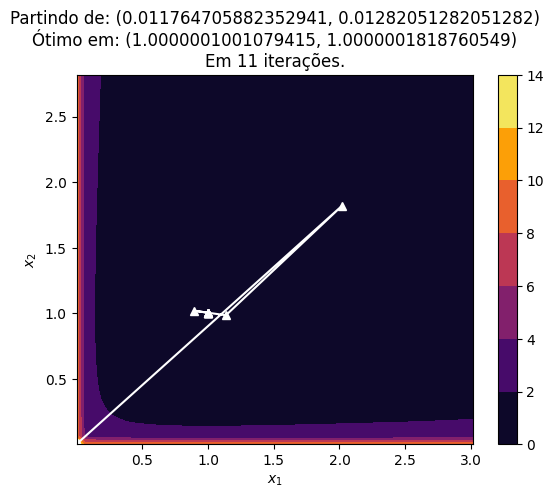

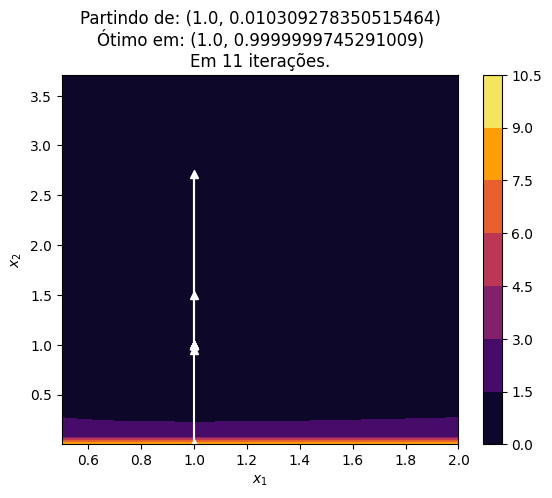

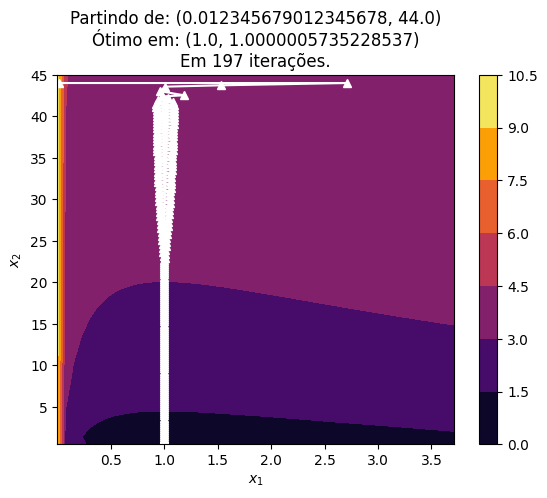

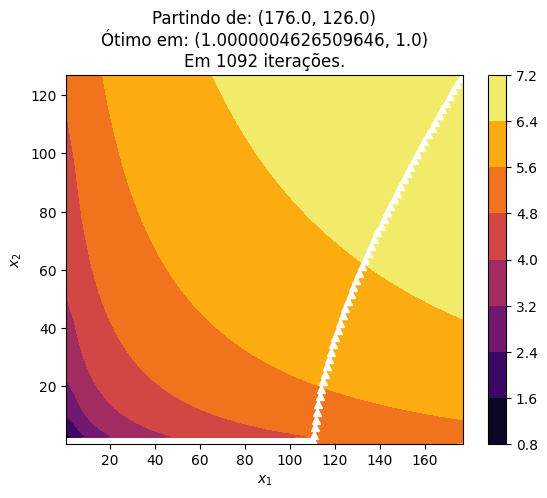

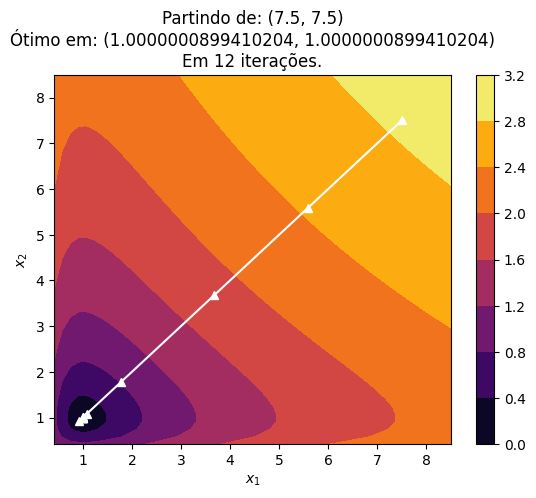

In [27]:
gradientPoints = simulate([canto,parede1,parede2,planalto,randomPoint],gradientMethod,"TABELA 1\n\nMÉTODO GRADIENTE")

for simulation in gradientPoints:
    plotPath(simulation)


#### Newton


 TABELA 2

MÉTODO DE NEWTON 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │           14 │             46 │ 1.032951 │ 0.993104 │ 0.033149 │           8.537e-07   │
│   1.0000 │   0.0103 │           52 │            121 │ 1.000000 │ 1.000000 │ 0.000000 │           2.22045e-16 │
│   0.0123 │  44.0000 │           48 │            113 │ 1.000351 │ 1.000174 │ 0.000391 │           3.56772e-07 │
│ 176.0000 │ 126.0000 │           33 │             83 │ 1.000000 │ 1.000000 │ 0.000000 │           4.06725e-07 │
│   7.5000 │   7.5000 │           16 │             49 │ 1.000274 │ 1.000274 │ 0.000388 │           1.02167e-07 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════

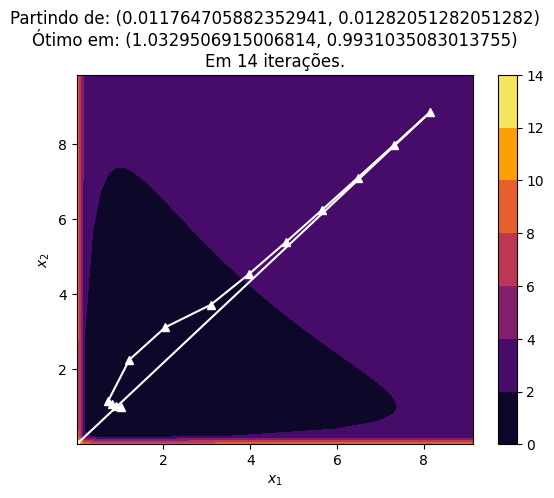

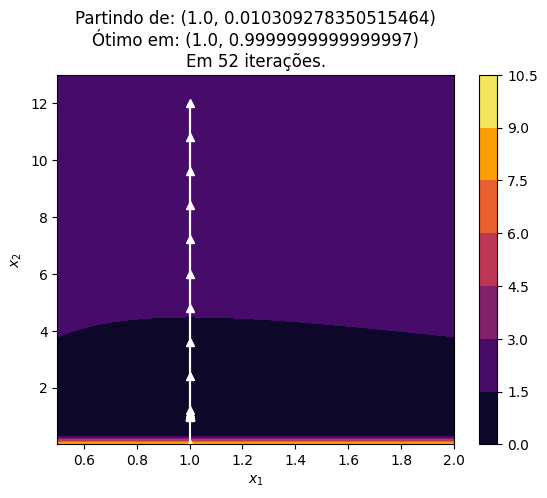

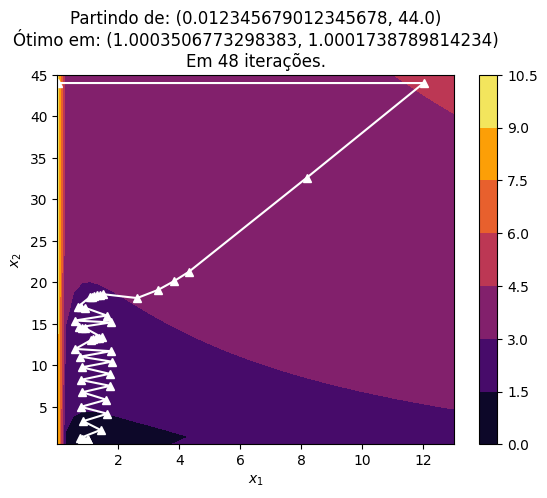

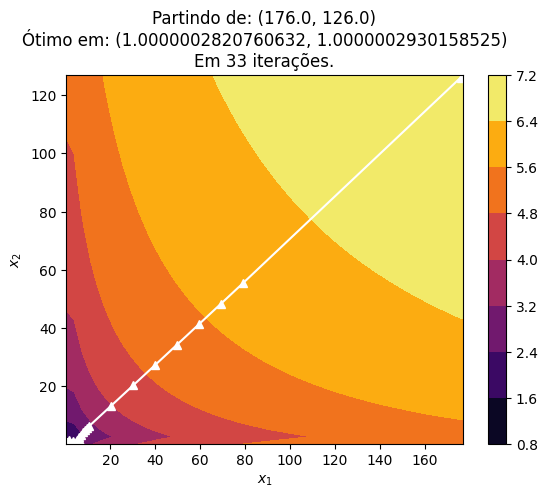

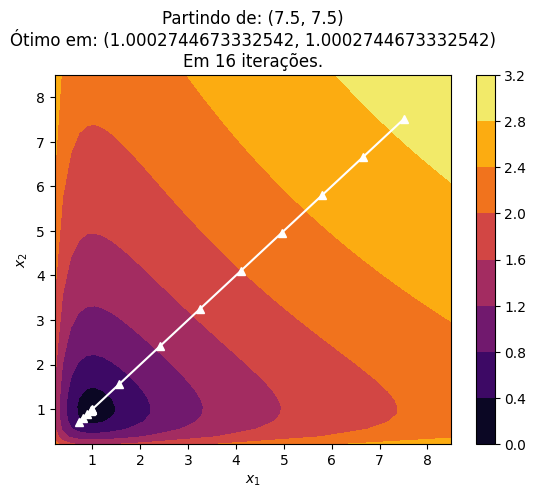

In [28]:
newtonPoints = simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethod,"TABELA 2\n\nMÉTODO DE NEWTON")

for simulation in newtonPoints:
    plotPath(simulation)


#### Quasi Newton


 TABELA 3

MÉTODO BFGS 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │           57 │            129 │ 1.000000 │ 1.000000 │ 0.000000 │           7.50777e-15 │
│   1.0000 │   0.0103 │           50 │            116 │ 1.000000 │ 1.000000 │ 0.000000 │           1.11022e-16 │
│   0.0123 │  44.0000 │           58 │            131 │ 1.000000 │ 1.000000 │ 0.000000 │           6.66134e-16 │
│ 176.0000 │ 126.0000 │          685 │           1386 │ 1.000000 │ 1.000000 │ 0.000000 │           8.67112e-16 │
│   7.5000 │   7.5000 │           35 │             85 │ 1.000000 │ 1.000000 │ 0.000000 │           1.57009e-15 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════╧════

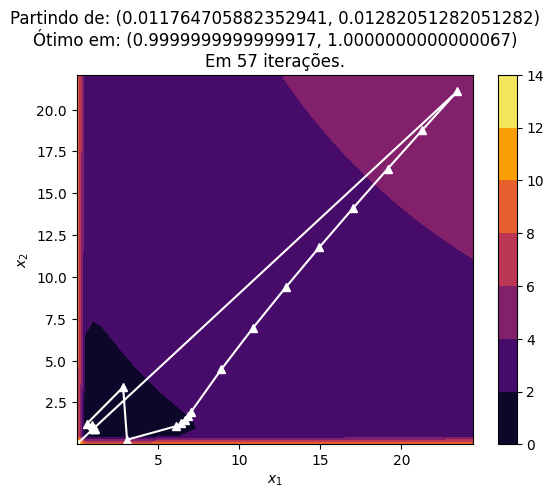

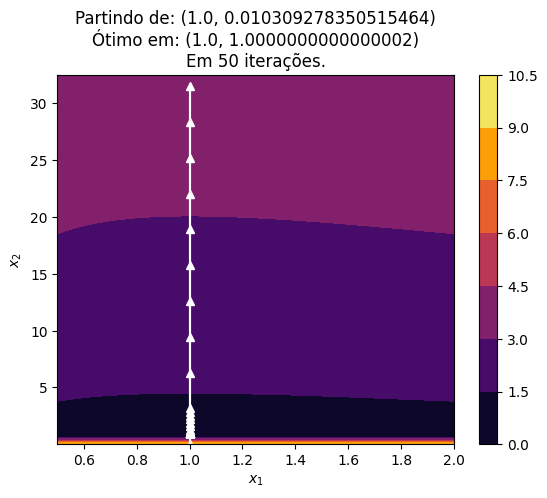

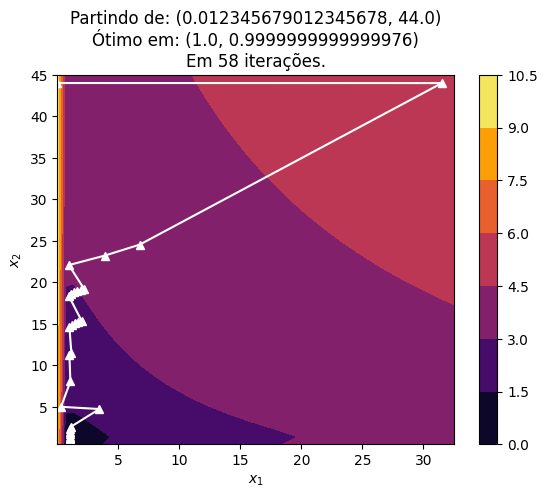

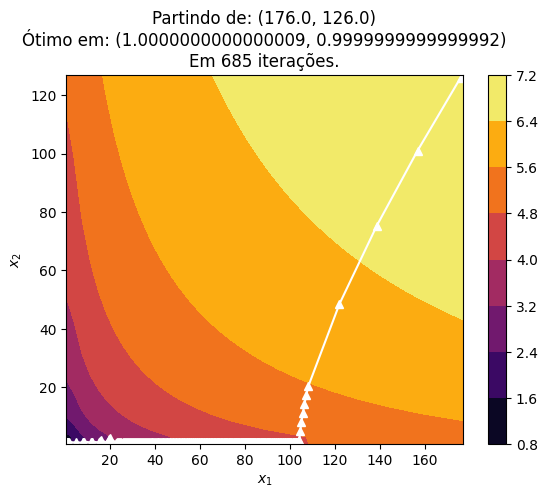

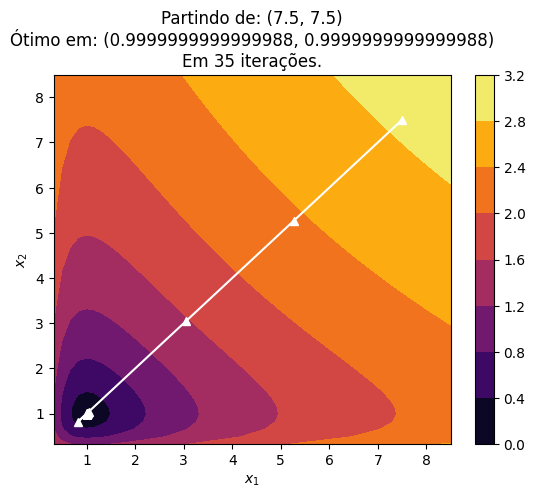

In [29]:
quasiNewtonPoints = simulate([canto,parede1,parede2,planalto,randomPoint],quasiNewtonMethod,"TABELA 3\n\nMÉTODO BFGS")

for simulation in quasiNewtonPoints:
    plotPath(simulation)


#### 4 Direções


 TABELA 4

MÉTODO DAS 4 DIREÇÕES 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │            7 │            325 │ 1.000000 │ 1.000000 │ 0.000000 │           2.33153e-08 │
│   1.0000 │   0.0103 │            8 │            537 │ 1.000000 │ 1.000000 │ 0.000000 │           2.14693e-08 │
│   0.0123 │  44.0000 │           41 │           3187 │ 1.000000 │ 1.000000 │ 0.000000 │           3.08691e-08 │
│ 176.0000 │ 126.0000 │          140 │          10449 │ 1.000000 │ 1.000000 │ 0.000000 │           6.57179e-08 │
│   7.5000 │   7.5000 │            6 │            532 │ 1.000000 │ 1.000000 │ 0.000000 │           7.3811e-15  │
╘══════════╧══════════╧══════════════╧════════════════╧═════

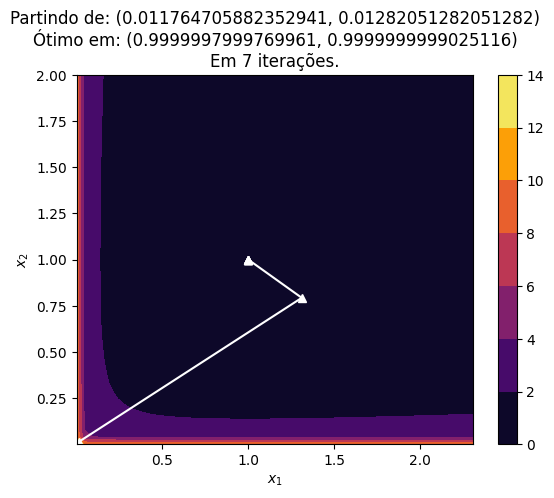

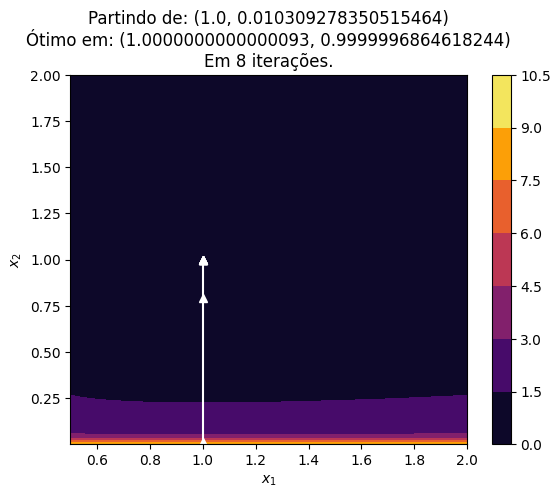

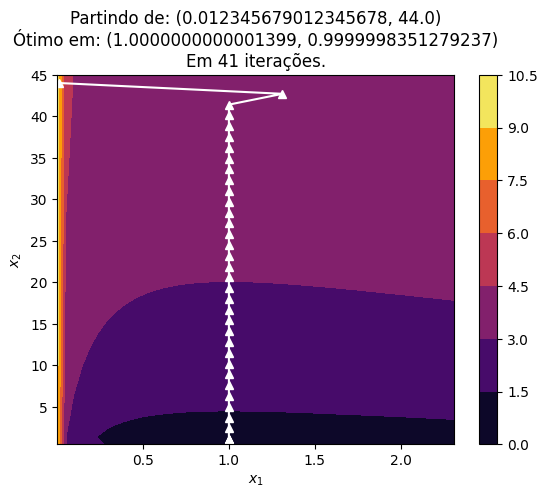

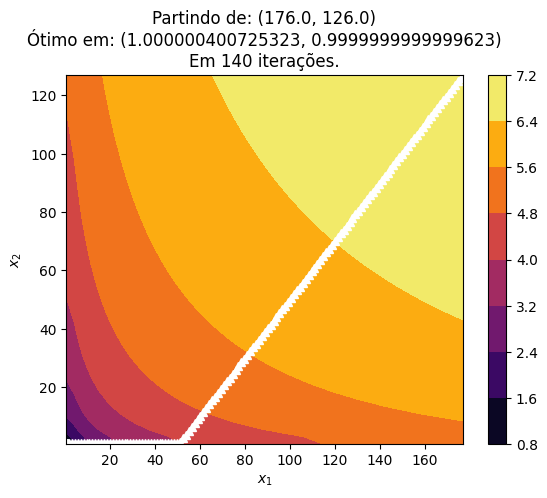

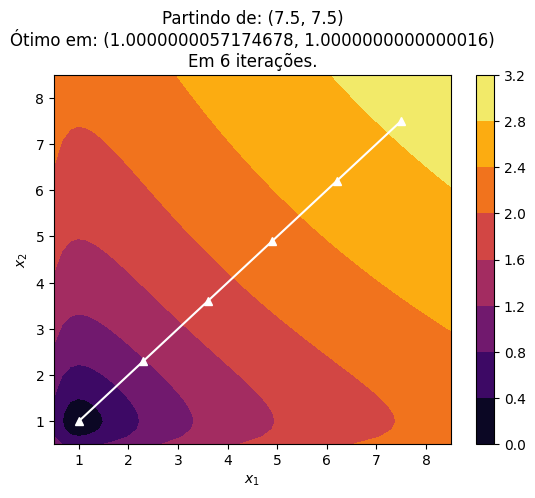

In [30]:
mockPoints = simulate([canto,parede1,parede2,planalto,randomPoint],mockMethod2,"TABELA 4\n\nMÉTODO DAS 4 DIREÇÕES")

for simulation in mockPoints:
    plotPath(simulation)

### 4.2 - Problemas de Convergência do Método de Newton e BFGS

Dado anteriormente que os métodos de newton e quase-newton produzem direções ruins para a regra de armijo, estes precisaram ser ajustados para as simulações anteriores, mas seguem as simulações para os mesmos pontos com os métodos sem ajustes.

A regra de Armijo(implementada) tem como condição de parada a detecção de decrescimento, se for aplicada a um direção de subida ou de não descida não acarretará em mudança de ponto, portanto não convergirá. Essa função em específico como não tem minimos locais além do mínimo global ela converge bem com o método do gradiente, mas como não apresenta convexidade para todo seu domínio, os métodos de Newton e BFGS precisam de ajustes na direção a ser aplicada no armijo a depender da convexidade no ponto.

#### Newton Problemático


 TABELA 5

MÉTODO DE NEWTON SEM AJUSTES 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤═══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │    X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪═══════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │            1 │             35 │ 0.011765 │  0.012821 │ 6.222383 │           9.47279e-07 │
│   1.0000 │   0.0103 │            1 │             35 │ 1.000000 │  0.010309 │ 4.574710 │           9.78503e-07 │
│   0.0123 │  44.0000 │           16 │             40 │ 0.005977 │ 11.750001 │ 5.681798 │           5.88248e-07 │
│ 176.0000 │ 126.0000 │          102 │            134 │ 0.972283 │  0.767814 │ 0.265698 │           3.40363e-07 │
│   7.5000 │   7.5000 │            6 │             38 │ 0.962798 │  0.962798 │ 0.053615 │           4.5222e-07  │
╘══════════╧══════════╧══════════════╧═══════

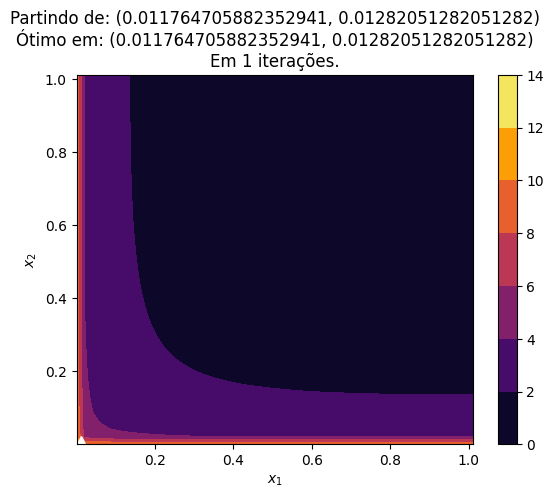

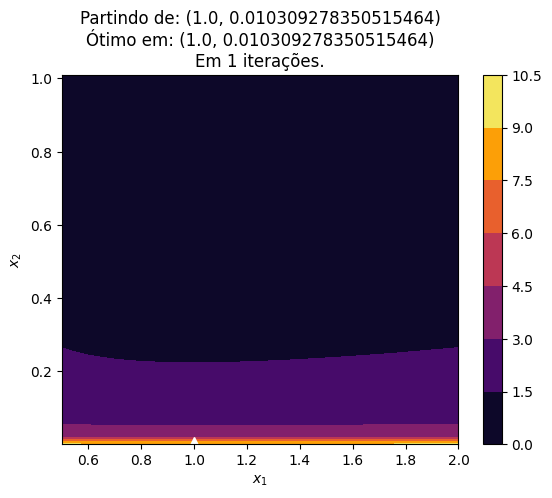

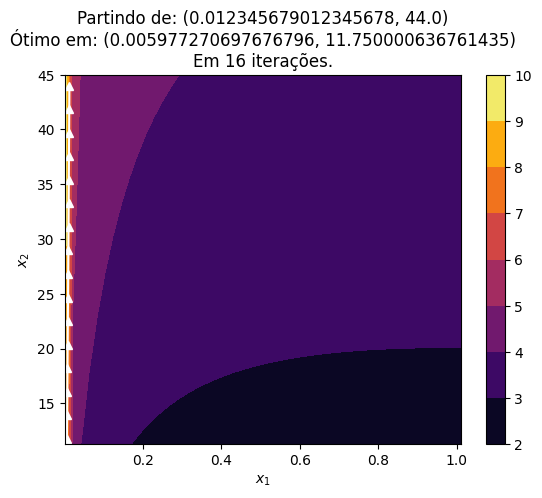

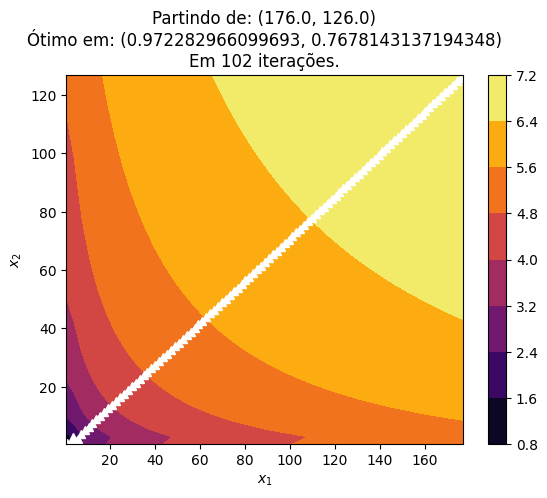

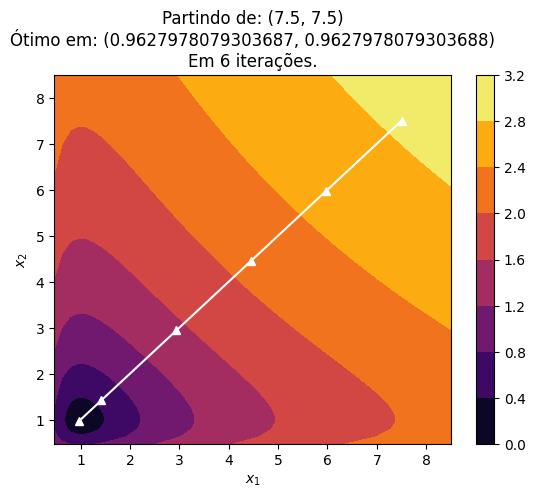

In [31]:
newtonBrokenPoints = simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethodBroken,"TABELA 5\n\nMÉTODO DE NEWTON SEM AJUSTES")

for simulation in newtonBrokenPoints:
    plotPath(simulation)


#### BFGS Problemático

iteration limit

 TABELA 6

MÉTODO BFGS SEM AJUSTES 

╒══════════╤══════════╤══════════════╤════════════════╤════════════╤════════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │     X*(x1) │     X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪════════════╪════════════╪══════════╪═══════════════════════╡
│   0.0118 │   0.0128 │           19 │             28 │   1.044928 │   0.960411 │ 0.059691 │           6.57462e-07 │
│   1.0000 │   0.0103 │           23 │             33 │   0.929370 │   1.089679 │ 0.112877 │           2.79286e-07 │
│   0.0123 │  44.0000 │        10001 │          10009 │   0.923363 │  43.760740 │ 3.779578 │           1.60335e-07 │
│ 176.0000 │ 126.0000 │            2 │             15 │ 175.301044 │ 125.086786 │ 7.071922 │           4.72515e-07 │
│   7.5000 │   7.5000 │            2 │             17 │   6.686827 │   6.686827 │ 2.687203 │           5.38438e-08 │
╘═════════

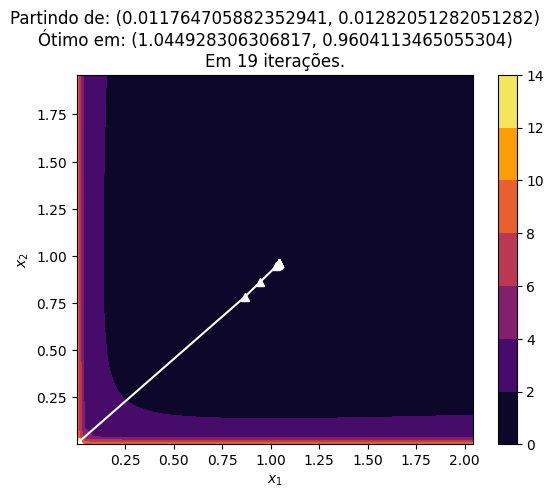

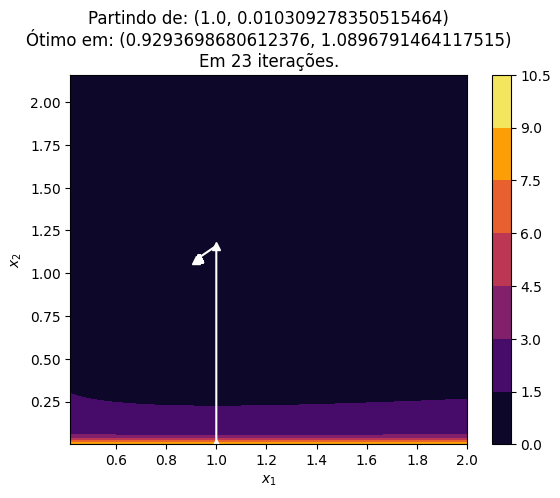

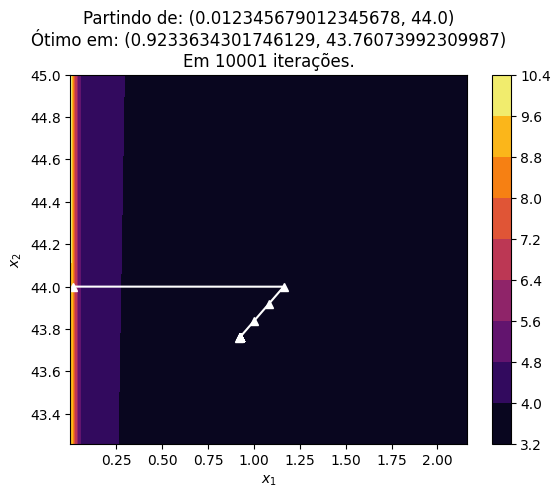

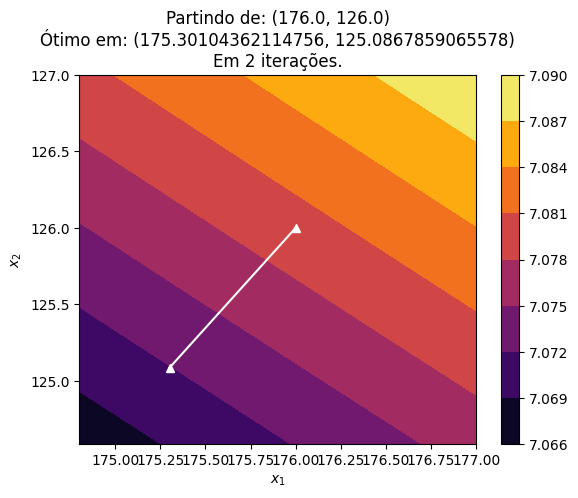

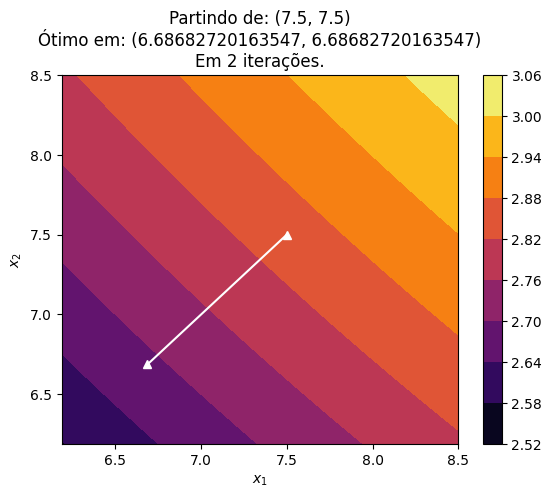

In [32]:
quasiNewtonBrokenPoints = simulate([canto,parede1,parede2,planalto,randomPoint],quasiNewtonMethodBroken,"TABELA 6\n\nMÉTODO BFGS SEM AJUSTES")

for simulation in quasiNewtonBrokenPoints:
    plotPath(simulation)

## 5 - Otimização dos Parâmetros S, $\beta$ e $\sigma$

Como os parâmetros podem assumir infinitas combinações é impossível testar todas, mas é possível a partir de sucessivos testes com diferentes pontos encontrar parâmetros que funcionem de forma razoável para um determinado método em vários pontos.

Testes que vão usar um algoritmo evolutivo para selecionar os melhores parâmetros:

#### Iniciando com Parâmetros Aleatórios

In [33]:
def initiateGen(population):
    generated = []
    for i in range(population):
        newS, newBeta, newSigma = (random()/random()) + 1, random(), random()
        generated += [{"S":newS, 'beta':newBeta,'sigma':newSigma, 'fitness':""}]
    return generated

#### Recombinando uma População de Pais

In [34]:
def recombinate(parents):
    childs = []
    for index1 in range(len(parents)):
        for index2 in range(index1 + 1,len(parents)):
            pS1, pS2, pb1, pb2, ps1, ps2 = parents[index1]['S'], parents[index2]['S'], parents[index1]['beta'], parents[index2]['beta'], parents[index1]['sigma'], parents[index2]['sigma']
            childS, childBeta, childSigma = pS1*random() + pS2*random() + 1, (pb1 + pb2)/2, (ps1 + ps2)/2
            childs += [{'S': childS, 'beta': childBeta, 'sigma':childSigma, 'fitness':""}]
    return childs


#### Busca por Melhores Individuos Depois de 300 Gerações

Não é utilizada mutação, pois individuos aleatórios são introduzidos toda geração.

In [35]:
def algoGenSearch(point, method, elite = 4, randomized = 2, generations = 300):
    population = (elite + randomized)*(elite + randomized + 1)
    currentPopulation = initiateGen(population)
    searching = True
    topOnes = []
    while(searching):
        generations -= 1
        for individual in currentPopulation:
            
            evaluation = method(point,S = individual['S'], beta = individual['beta'], sigma = individual['sigma'])
            individual['fitness'] = evaluation['stepSizeCalls']
            #alguma forma de inserir individual nos TopOnes
            pushing = True
            for i in range(len(topOnes)):
                if topOnes[i]['fitness'] > individual['fitness'] and evaluation['currentValue'] < .00000001 and pushing: 
                    topOnes.insert(i, individual)
                    pushing = False
            if pushing: topOnes += [individual]
        #print(topOnes[0]['fitness'], topOnes[elite-1]['fitness'])
        topOnes = topOnes[0:(elite)]
        #print(topOnes)
        if (generations < 1): 
            #print(generations)
            searching = False
        newOnes = initiateGen(randomized)
        childs = recombinate(topOnes + newOnes)
        currentPopulation = newOnes + childs
        #print(generations)    
    return(topOnes[0])    


#### Aplicando A Busca para Diferentes Pontos e Diferentes Métodos

In [36]:
def fullSearch(pointList, methodList, elite = 4, randomized = 2, generations = 300):
    for method in methodList:
        for point in pointList:
            print(f'\nPonto Buscado:{point}   Método Aplicado: {method.__name__}\n')
            print(algoGenSearch(point, method, elite, randomized, generations))
            

In [37]:
points = [canto,parede1,parede2, planalto]
methods = [ newtonMethod]

fullSearch(points,methods)


Ponto Buscado:(0.011764705882352941, 0.01282051282051282)   Método Aplicado: newtonMethod



/tmp/ipykernel_42616/2808663487.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.log(x1)/(denom*x1), np.log(x2)/(denom*x2)
/tmp/ipykernel_42616/3385429188.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  a1 = (1/x1**2)*(((1-log1)/(func))-(log1**2/func3))
/tmp/ipykernel_42616/3385429188.py:5: RuntimeWarning: invalid value encountered in scalar divide
  a1 = (1/x1**2)*(((1-log1)/(func))-(log1**2/func3))
/tmp/ipykernel_42616/3385429188.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  a2 = (1/x2**2)*(((1-log2)/(func))-(log2**2/func3))
/tmp/ipykernel_42616/3385429188.py:6: RuntimeWarning: invalid value encountered in scalar divide
  a2 = (1/x2**2)*(((1-log2)/(func))-(log2**2/func3))
/tmp/ipykernel_42616/3385429188.py:7: RuntimeWarning: invalid value encountered in scalar divide
  b = (-1)*(log1*log2)/(x1*x2*func3)


RecursionError: maximum recursion depth exceeded while calling a Python object